In [1]:
import pandas as pd
from scipy.stats import chisquare

In [2]:
#Load Data as arrays
RA = pd.read_csv('RANorm.csv', names=['arrival'], usecols=[1])
RD = pd.read_csv('RDNorm.csv', names=['departure'], usecols=[1])
LA = pd.read_csv('LANorm.csv', names=['arrival'], usecols=[1])
LD = pd.read_csv('LDNorm.csv', names=['departure'], usecols=[1])

In [3]:
# Convertime string to seconds
RD["departure"] = pd.to_timedelta(RD["departure"].radd("00:")).dt.total_seconds()
RA["arrival"] = pd.to_timedelta(RA["arrival"].radd("00:")).dt.total_seconds()
LD["departure"] = pd.to_timedelta(LD["departure"].radd("00:")).dt.total_seconds()
LA["arrival"] = pd.to_timedelta(LA["arrival"].radd("00:")).dt.total_seconds()

In [4]:
# Merge into right and left Dataframes
right = pd.concat([RA, RD], axis=1)
left = pd.concat([LA, LD], axis=1)

In [5]:
# add delta, minimum 0
right['delta'] = right['departure'] - right['arrival']
right['delta'] = right['delta'].clip(lower=0)
left['delta'] = left['departure'] - left['arrival']
left['delta'] = left['delta'].clip(lower=0)

In [6]:
# on top of this, plot mixture of an exponential distributions with mean 5 and gaussian with mean 55
from scipy.stats import expon, norm, chi2
import numpy as np
import matplotlib.pyplot as plt

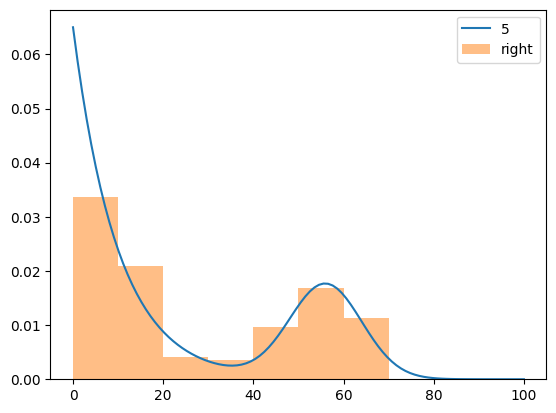

In [7]:
x = np.linspace(0, 100, 100)

# now do a mixture of two gaussians with means 5 and 55 and weights 0.5 and 0.5
plt.plot(x, 0.65*expon.pdf(x, 0, 10) + 0.35*norm.pdf(x, 56, 8), label='5')

# Plot histogram of left servings on the same plot with each bin being a proportion of the total
plt.hist(right['delta'], bins=[0, 10, 20, 30, 40, 50, 60, 70], alpha=0.5, label='right', density=True)
# plt.hist(left['delta'], bins=[0, 20, 40, 60, 80], alpha=0.5, label='left', density=True)

# now show the histogram
plt.legend()

plt.show()

In [8]:
# Assign slow, medium, fast categories
# 0-20 fast, 20-40 medium, 40+ slow
bins = [-1, 20, 40, 1000]
labels = ['fast', 'medium', 'slow']
right['category'] = pd.cut(right['delta'], bins=bins, labels=labels)
left['category'] = pd.cut(left['delta'], bins=bins, labels=labels)

In [9]:
pd.options.display.max_rows = 250
print(right)

     arrival  departure  delta category
0       0.74      54.31  53.57     slow
1       2.74      57.06  54.32     slow
2       7.69      58.59  50.90     slow
3      16.40      60.89  44.49     slow
4      17.94      63.26  45.32     slow
5      18.59      63.69  45.10     slow
6      25.54      65.62  40.08     slow
7      47.36      65.95  18.59     fast
8      55.87      67.63  11.76     fast
9      57.79      68.60  10.81     fast
10     69.35      69.90   0.55     fast
11     72.39      72.39   0.00     fast
12     74.46      74.55   0.09     fast
13     75.90      75.93   0.03     fast
14     77.61      77.72   0.11     fast
15     79.77      79.77   0.00     fast
16     81.19      81.19   0.00     fast
17     86.34      86.34   0.00     fast
18     89.33      89.57   0.24     fast
19     90.95      91.20   0.25     fast
20     94.65      94.86   0.21     fast
21     96.65      96.79   0.14     fast
22     98.94      98.94   0.00     fast
23    100.69     100.88   0.19     fast


## Chi-Squared Goodness of Fit Test
Null Hypothesis: The distribution of the data is not the same as the distribution of the expected values
Alternative Hypothesis: The distribution of the data is the same as the distribution of the expected values

In [10]:
def mixture_cdf(x):
    return 0.65*expon.cdf(x, 0, 10) + 0.35*norm.cdf(x, 56, 8)

p = []

for i in range(1, len(bins)):
    p.append(mixture_cdf(bins[i]) - mixture_cdf(max(bins[i-1], 0)))

In [15]:
# Chi squared for right
exp_right = np.array(p) * len(right)
# exp_right = np.array(p) * len(right)
obs_right_counts = right['category'].value_counts()
obs_right = []

for i in labels:
    obs_right.append(obs_right_counts[i])

chisquare(obs_right, exp_right)

Power_divergenceResult(statistic=0.5301909550262623, pvalue=0.7671327025564889)

In [16]:
exp_right

array([110.158518  ,  16.46872866,  69.37275334])

In [12]:
# Chi squared for left
exp = np.array(p) * len(left)
obs_left_counts = left['category'].value_counts()
obs_left = []

for i in labels:
    obs_left.append(obs_left_counts[i])

chisquare(obs_left, exp)


Power_divergenceResult(statistic=21.987368980164494, pvalue=1.6807514328752348e-05)

For both lanes, the p value is lower than 0.95, so we do not reject the null hypothesis. Therefore, the data does not necessarily follow this model.